
# Multilayer Perceptron (MLP) Image Classifier for Persian Numbers 

Due to privacy issues, the CNN model is applied to SVHN dataset here. <br>
Same model can be trained for a dataset including Persian numbers
[SVHN dataset](http://ufldl.stanford.edu/housenumbers/)

Reference:
* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.


In [27]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import regularizers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.initializers import he_uniform, glorot_normal, zeros, ones
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
# loading dataset
# dictionaries with keys `X` and `y` for the input images and labels respectively.
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

## Visualization fucntions

In [29]:
def show_images(n,image_array,label_array, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    '''
    total_rows = math.floor(n/4)+1
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(total_rows, 4, figsize=(16, total_rows*4))
    [axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    r = 0
    c = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        #axes[r, c].set_axis_off()
        axes[r, c].imshow(np.squeeze(image), cmap=cmap)
        axes[r, c].set_title(f"Label: {label_array[i]} \n {i}th image in the dataset.")
        c += 1
        if c % 4 == 0:
            r += 1
            c = 0
    plt.show()

In [30]:
def show_images_predictions(n,image_array,label_array1,label_array2, cmap=None):
    '''
    show random n number of images from image_array with corresponding label_array
    the precition of class probablity distibution from each model also would be discplayed
    '''
    random_list = random.sample(range(0, image_array.shape[0]), n)
    fig, axes = plt.subplots(n, 2, figsize=(16, n*6))
    #[axi.set_axis_off() for axi in axes.ravel()] # this line sets all axis off
    category_list1 = list(map(lambda x : x + 0.15, list(range(10)))) 
    category_list2 = list(map(lambda x : x - 0.15, list(range(10)))) 
    r = 0
    for i in random_list:
        image = image_array[i,:,:,:]
        axes[r, 0].set_axis_off()
        axes[r, 0].imshow(np.squeeze(image), cmap=cmap)
        #axes[r, 1].set_title(f"{i}th image in the dataset.")
        axes[r, 1].bar(category_list1,label_array1[i], width=0.3, label='MLP')
        axes[r, 1].bar(category_list2,label_array2[i], width=0.3, label='CNN')
        axes[r, 1].set_title(f"Prediction from MLP model: {np.argmax(label_array1[i,:])} \n Prediction from CNN model: {np.argmax(label_array2[i,:])} ")
        axes[r, 1].legend()
        r += 1
    plt.show()

In [ ]:
# Functions to plot accuacy and loss
def plot_acc(history):
    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show() 


def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 

## Preprocessing

In [31]:
train_images = train['X'] 
train_labels = train['y']
test_images = test['X'] 
test_labels = test['y']

# scaling the numbers
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshaping the inputs
train_images = np.moveaxis(train_images,-1,0)
test_images = np.moveaxis(test_images,-1,0)

# changing 0 number label from 10 to 0
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

In [32]:
train_images_grey = np.mean(train_images, axis=3)
train_images_grey = np.expand_dims(train_images_grey, axis=3) # add the channel dimension
test_images_grey = np.mean(test_images, axis=3)
test_images_grey = np.expand_dims(test_images_grey, axis=3) # add the channel dimension

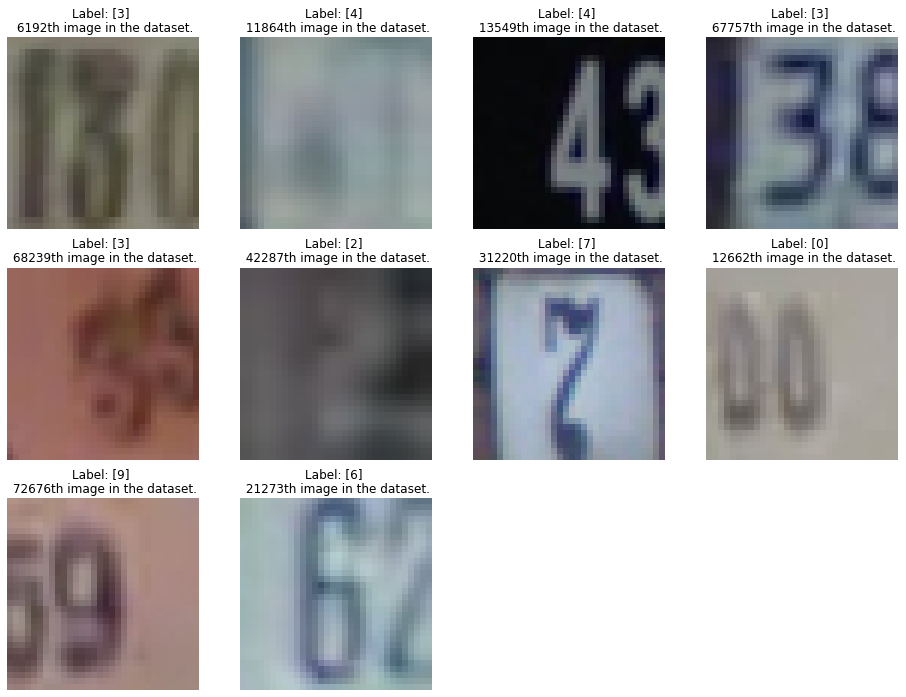

In [33]:
n = 10 # number of images to show
# showing images and correspoind labels from train set
show_images(n,train_images,train_labels)

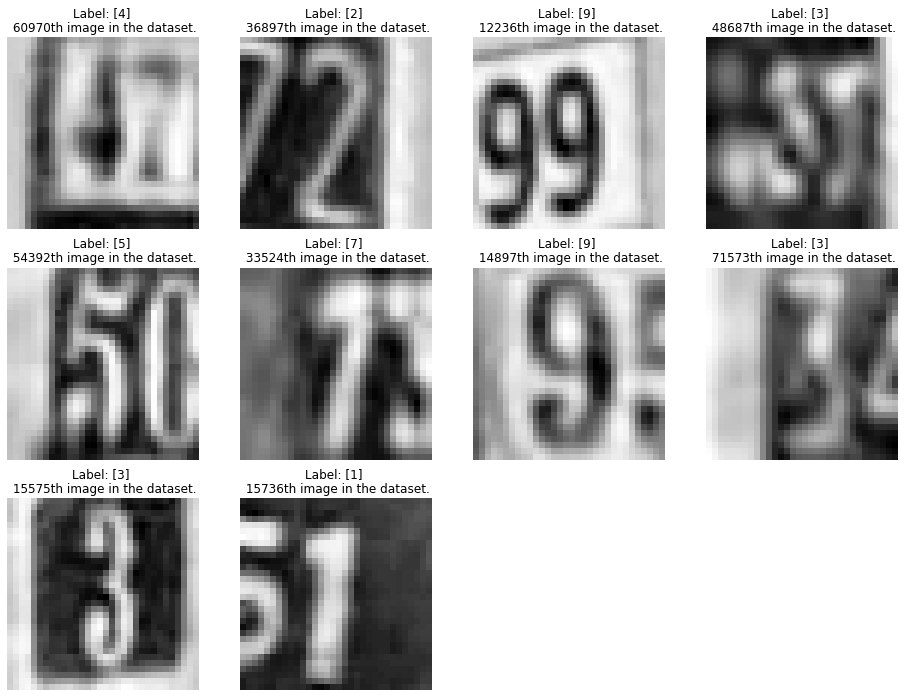

In [34]:
n = 10 # number of images to show
# showing greay images and correspoind labels from train set
show_images(n,train_images_grey,train_labels, cmap='Greys')

## MLP neural network classifier


In [35]:

def MLP_NN(input_shape, reg_rate):
    '''
    Multilayer Perceptron (MLP) classification model
    '''
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu', kernel_initializer="he_uniform", bias_initializer="ones",
              kernel_regularizer=regularizers.l2(reg_rate), name='dense_1_relu'),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_2_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_3_relu'),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='dense_4_relu'),
        Dense(10, activation='softmax', name='dense_5_softmax')
    ])
    return model

In [36]:
def get_checkpoint_best_only(checkpoint_path):
    '''
    save best weights of the model with monitoring validation accuract
    '''
    checkpoint = ModelCheckpoint(checkpoint_path,
                                 save_weights_only=True,
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True)
    
    return checkpoint

In [37]:
def get_test_accuracy(model, x_test, y_test):
    '''
    checking the accuracy of the model on the test sets
    '''
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(' test accuracy: {acc:0.3f}'.format(acc=test_acc), '\n',
          'test loss: {loss:0.3f}'.format(loss=test_loss))

In [38]:
# creating MLP model for greay scale images
model_MLP = MLP_NN(input_shape=(32,32,1), reg_rate=1e-4)
model_MLP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1_relu (Dense)         (None, 256)               262400    
_________________________________________________________________
dense_2_relu (Dense)         (None, 256)               65792     
_________________________________________________________________
dense_3_relu (Dense)         (None, 128)               32896     
_________________________________________________________________
dense_4_relu (Dense)         (None, 128)               16512     
_________________________________________________________________
dense_5_softmax (Dense)      (None, 10)                1290      
Total params: 378,890
Trainable params: 378,890
Non-trainable params: 0
________________________________________________

In [39]:
model_MLP.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [40]:
checkpoint_best_only = get_checkpoint_best_only('Trained models weights\checkpoints_best_only_MLP\checkpoint')

history_MLP = model_MLP.fit(train_images_grey,
                            train_labels,
                            batch_size=64,
                            epochs=30,
                            validation_split=0.10,
                            callbacks=[EarlyStopping(monitor='val_accuracy', patience=4), checkpoint_best_only]
                           )

Epoch 1/30
1029/1031 [============================>.] - ETA: 0s - loss: 1.9774 - accuracy: 0.3170
Epoch 00001: val_accuracy improved from -inf to 0.48594, saving model to Trained models weights\checkpoints_best_only_MLP\checkpoint
1031/1031 [==============================] - 16s 15ms/step - loss: 1.9769 - accuracy: 0.3172 - val_loss: 1.5468 - val_accuracy: 0.4859
Epoch 2/30
1029/1031 [============================>.] - ETA: 0s - loss: 1.3478 - accuracy: 0.5640
Epoch 00002: val_accuracy improved from 0.48594 to 0.60347, saving model to Trained models weights\checkpoints_best_only_MLP\checkpoint
1031/1031 [==============================] - 9s 9ms/step - loss: 1.3477 - accuracy: 0.5641 - val_loss: 1.2371 - val_accuracy: 0.6035
Epoch 3/30
1022/1031 [============================>.] - ETA: 0s - loss: 1.1365 - accuracy: 0.6481
Epoch 00003: val_accuracy improved from 0.60347 to 0.62804, saving model to Trained models weights\checkpoints_best_only_MLP\checkpoint
1031/1031 [======================

1026/1031 [============================>.] - ETA: 0s - loss: 0.7215 - accuracy: 0.7930
Epoch 00015: val_accuracy did not improve from 0.78256
1031/1031 [==============================] - 9s 9ms/step - loss: 0.7214 - accuracy: 0.7931 - val_loss: 0.7648 - val_accuracy: 0.7813
Epoch 16/30
1030/1031 [============================>.] - ETA: 0s - loss: 0.7162 - accuracy: 0.7948
Epoch 00016: val_accuracy improved from 0.78256 to 0.78952, saving model to Trained models weights\checkpoints_best_only_MLP\checkpoint
1031/1031 [==============================] - 10s 10ms/step - loss: 0.7162 - accuracy: 0.7948 - val_loss: 0.7587 - val_accuracy: 0.7895
Epoch 17/30
1029/1031 [============================>.] - ETA: 0s - loss: 0.6969 - accuracy: 0.8012
Epoch 00017: val_accuracy did not improve from 0.78952
1031/1031 [==============================] - 9s 8ms/step - loss: 0.6968 - accuracy: 0.8013 - val_loss: 0.7924 - val_accuracy: 0.7701
Epoch 18/30
1031/1031 [==============================] - ETA: 0s - l

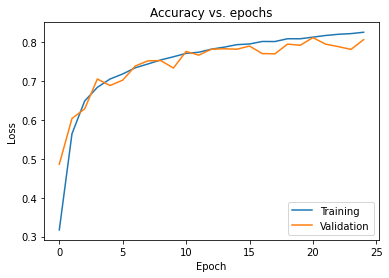

In [42]:
plot_acc(history_MLP)

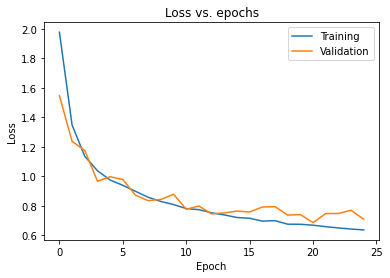

In [43]:
plot_loss(history_MLP)

In [44]:
get_test_accuracy(model_MLP, test_images_grey, test_labels)

 test accuracy: 0.779 
 test loss: 0.817


## Model predictions

In [45]:
def get_model_best_epoch(model, checkpoint_path):
    '''
    get model saved best epoch
    '''
    model.load_weights(checkpoint_path)
    
    return model

In [46]:
# MLP model best epoch
model_MLP = MLP_NN(input_shape=(32,32,1), reg_rate=1e-4)
model_MLP = get_model_best_epoch(model_MLP, 'Trained models weights\checkpoints_best_only_MLP\checkpoint')

In [47]:
prediction_MLP = model_MLP.predict(test_images_grey)
prediction_MLP_final = np.argmax(prediction_MLP, axis=1) # finding the maximum category
prediction_MLP_final = np.expand_dims(prediction_MLP_final, axis=1) # add the channel dimension

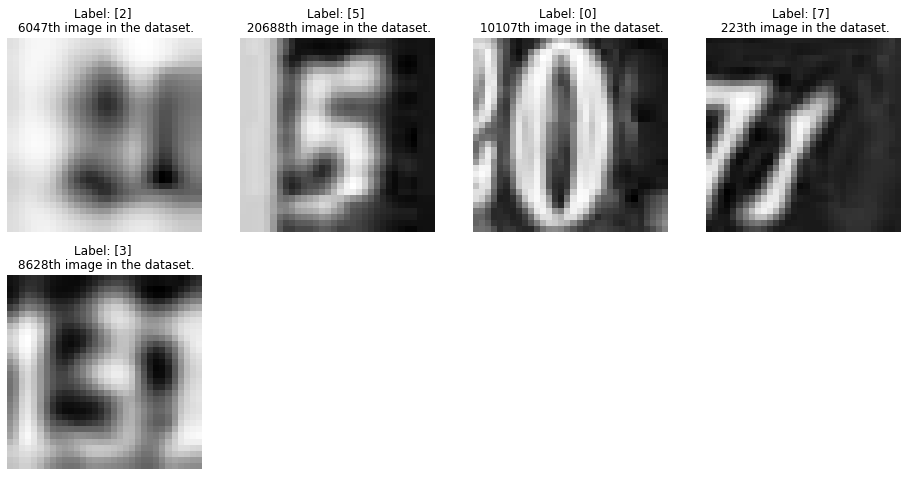

In [48]:
n = 5 # number of images to show
show_images(n,test_images_grey,prediction_MLP_final, cmap='Greys')

## Comparison
To do a comparison between MLP and CNN model, the CNN model is created here and the trained wights are loaded

In [51]:
def CNN_NN(input_shape, dropout_rate, reg_rate):
    model = Sequential([
        Conv2D(8, (3,3), activation='relu', input_shape=input_shape, 
               kernel_initializer="he_uniform", bias_initializer="ones", 
               kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_1_1_relu'),
        BatchNormalization(),
        Conv2D(16, (3,3), activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_2_2_relu'),
        MaxPool2D((3,3), strides=(2, 2), name='MaxPool2D_1_2_relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='CONV2D_3_3_relu'),
        MaxPool2D((3,3), strides=(2, 2), name='MaxPool2D_2_3_relu'),
        Dropout(dropout_rate),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='Dense_1_4_relu'),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(reg_rate), name='Dense_2_5_relu'),
        Dense(10, activation='softmax', name='Dense_3_6_softmax')
    ])
    return model

model_CNN = CNN_NN(input_shape= (32,32,1), dropout_rate = 0.3, reg_rate=1e-3)
model_CNN = get_model_best_epoch(model_CNN, 'Trained models weights\checkpoints_best_only_CNN\checkpoint')
prediction_CNN = model_CNN.predict(test_images_grey)
prediction_CNN_final = np.argmax(prediction_CNN, axis=1) # finding the maximum category
prediction_CNN_final = np.expand_dims(prediction_CNN_final, axis=1) # add the channel dimension

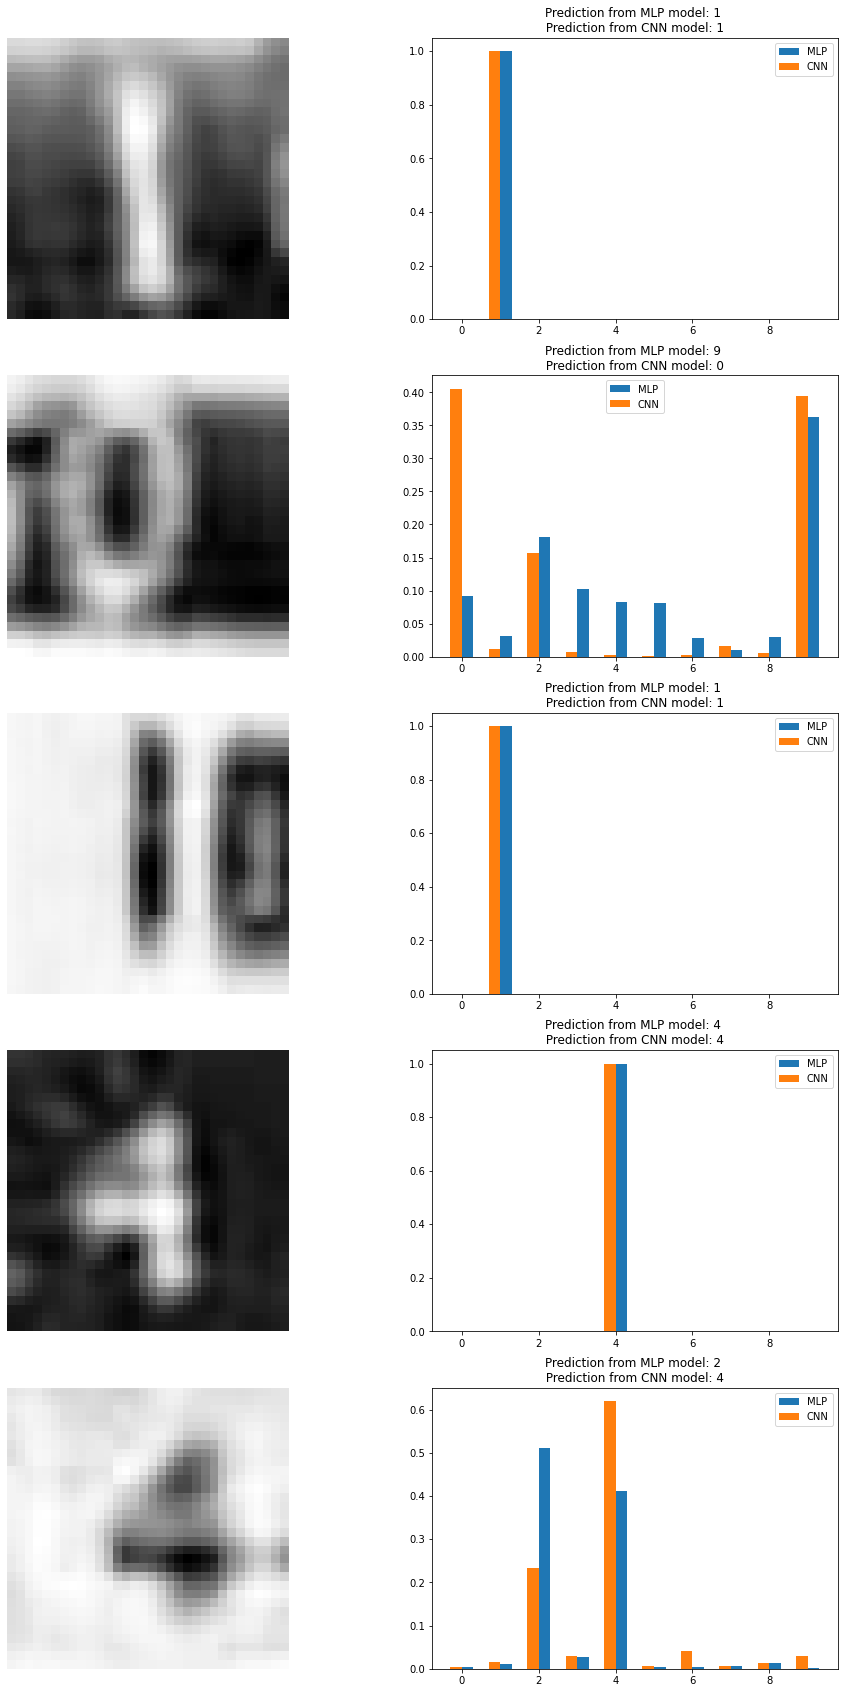

In [54]:
n = 5 # number of random images
show_images_predictions(n,test_images_grey,prediction_MLP, prediction_CNN, cmap='Greys')